In [1]:
#pip install --upgrade numpy tensorflow

In [2]:
#pip install sionna

In [3]:
import torch 
import numpy as np
import matplotlib.pyplot as plt

Here we import Sionna at the same kernel. It is hard to do in single kernel, so it just for info and model parameters used

In [4]:
# You may install the required libraries from https://nvlabs.github.io/sionna/installation.html
# or generate channel here in google colab
# ---------------------------------------------------------------------------------------------
# Load the required libraries
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')
from sionna.phy.channel.tr38901 import Antenna, AntennaArray, UMa, UMi, RMa
from sionna.phy.channel import subcarrier_frequencies, cir_to_ofdm_channel, gen_single_sector_topology
from sionna.phy.ofdm import ResourceGrid

In [5]:
# ===========================
# 1️⃣ Define BS & UE Parameters
# ===========================
num_bs = 1  # Number of Base Stations
num_ue = 60  # Number of User Equipments было 100 уменьшила до 20
num_ue_ant = 4  # UE MIMO Antennas
batch_size = 10  # Number of parallel simulations было 10, уменьшила до 4
scenario = "UMa"  # Urban Macro (Can be "UMa", "UMi", "RMa")
min_bs_ut_dist = 100 # Minimum BS-UE distance in meters
ISD = 500 # Inter-Site Distance
bs_height = 25 # BS height in meters
ut_height = 1.5 # UE height in meters
UE_speed = 0.83 # UE speed in meters/second

# ===========================
# 2️⃣ Define Resource Grid
# ===========================
carrier_frequency = 3.5e9  # 2.14 or 3.5 GHz (mid-band 5G)
fft_size = 256  # FFT Size было 1024 уменьшила до 256
sc_spacing = 30e3  # Subcarrier Spacing (30 kHz for FR1)
num_ofdm_symbols = 1  # OFDM symbols per slot

# ===========================
# 3️⃣ Define Antenna Array Configurations
# ===========================
bs_array = AntennaArray(
    num_rows=4, # number of rows in BS antenna array
    num_cols=8, # number of columns in BS antenna array
    polarization="dual", # "single" or "dual"
    polarization_type="cross", # for single polarization, must be "V" or "H". For dual polarization, must be "VH" or "cross"
    antenna_pattern="38.901", # "omni" or "38.901"
    carrier_frequency=carrier_frequency,
    vertical_spacing=0.9, # 0.9-wavelength spacing between vertical antenna elements
    horizontal_spacing=0.5 # Half-wavelength spacing between horizontal antenna elements
)

ue_array = AntennaArray(
    num_rows=1, # number of rows in UE antenna array
    num_cols=2, # number of columns in UE antenna array
    polarization="dual", # "single" or "dual"
    polarization_type="cross", # for single polarization, must be "V" or "H". For dual polarization, must be "VH" or "cross"
    antenna_pattern="38.901", # "omni" or "38.901"
    carrier_frequency=carrier_frequency,
    vertical_spacing=1, # One-wavelength spacing between vertical antenna elements
    horizontal_spacing=1  # One-wavelength spacing between horizontal antenna elements
)

# ===========================
# 4️⃣ Select Channel Model
# ===========================
if scenario == "UMa":
  channel_model = UMa(carrier_frequency=carrier_frequency,
                      o2i_model= "low",
                      ut_array=ue_array,
                      bs_array=bs_array,
                      direction="downlink")
elif scenario == "UMi":
  channel_model = UMi(carrier_frequency=carrier_frequency,
                      o2i_model= "low",
                      ut_array=ue_array,
                      bs_array=bs_array,
                      direction="downlink")
elif scenario == "RMa":
  channel_model = RMa(carrier_frequency=carrier_frequency,
                      o2i_model= "low",
                      ut_array=ue_array,
                      bs_array=bs_array,
                      direction="downlink")

# ===========================
# 5️⃣ Set 3GPP Scenario Parameters
# ===========================
pre_topology = sionna.phy.channel.set_3gpp_scenario_parameters(
                      scenario=scenario.lower(),
                      min_bs_ut_dist=min_bs_ut_dist,  # Minimum BS-UE distance in meters
                      isd=ISD,  # Inter-Site Distance
                      bs_height=bs_height,  # BS height in meters
                      min_ut_height=ut_height,  # Minimum UE height in meters
                      max_ut_height=ut_height,  # Maximum UE height in meters
                      indoor_probability=0, # Probability of a UE to be indoor
                      min_ut_velocity=UE_speed, # ! meter/sec
                      max_ut_velocity=UE_speed)

min_bs_ut_dist, isd, bs_height, min_ut_height, max_ut_height, indoor_probability, min_ut_velocity, max_ut_velocity = pre_topology

-----------------------------------------------------
Size of output frequency domain channel tensor:
 batch_size = 10 
 UE number = 60 
 UE antenna number = 4 
 BS number = 1 
 BS antenna number = 64 
 number ofdm symbols = 1 
 Subcarriers number = 256
*********** Successful channel generation ***********


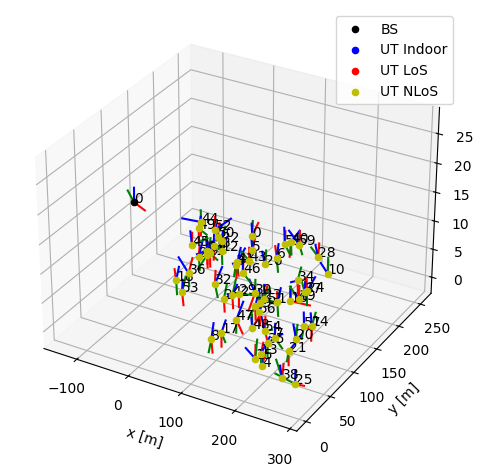

In [6]:
# ===========================
# 6️⃣ Generate Single Sector Topology
# ===========================
topology = gen_single_sector_topology(
                      batch_size=batch_size,
                      num_ut=num_ue,
                      isd=isd,
                      min_bs_ut_dist=min_bs_ut_dist,
                      scenario=scenario.lower(),
                      min_ut_height=min_ut_height,
                      max_ut_height=max_ut_height,
                      indoor_probability=indoor_probability,
                      min_ut_velocity=min_ut_velocity,
                      max_ut_velocity=max_ut_velocity)

ut_loc, bs_loc, ut_orientations, bs_orientations, ut_velocities, in_state = topology

# ===========================
# 7️⃣ Set Topology into the Channel Model
# ===========================
channel_model.set_topology(
    ut_loc,
    bs_loc,
    ut_orientations,
    bs_orientations,
    ut_velocities,
    in_state,
    los = False)# los=False=NLoS, los=True=LoS, None=LoS

channel_model.show_topology()

# ===========================
# 8️⃣ Simulate Time-Domain Channel
# ===========================
a, tau = channel_model(num_time_samples=num_ofdm_symbols,sampling_frequency=sc_spacing)  # Get channel impulse response (CIR)

# ===========================
# 9️⃣ Move Channel from Time to Frequency Domain
# ===========================
subcarrier_freqs = subcarrier_frequencies(fft_size, sc_spacing)
with tf.device('/GPU:0'):
    H_freq = cir_to_ofdm_channel(subcarrier_freqs, a, tau, normalize=True)# Convert CIR to OFDM channel


print("-----------------------------------------------------")
print(f"Size of output frequency domain channel tensor:\n batch_size = {H_freq.shape[0]} \n UE number = {H_freq.shape[1]} \n UE antenna number = {H_freq.shape[2]} \n BS number = {H_freq.shape[3]} \n BS antenna number = {H_freq.shape[4]} \n number ofdm symbols = {H_freq.shape[5]} \n Subcarriers number = {H_freq.shape[6]}")
print("*********** Successful channel generation ***********")

# ===========================
# ✅ Output Results
# ===========================
H_freq = np.transpose(np.squeeze(H_freq),(3,2,4,1,0)) # Output channel tensor H=[N_tx x N_rx x N_sc x N_ue x N_batch]

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cuda')

In [8]:
from scipy.io import savemat
savemat(f"Sionna_3GPP_{scenario.upper()}_Channel.mat", {'Hfrq': H_freq})
#from google.colab import files
#files.download(f"Sionna_3GPP_{scenario.upper()}_Channel.mat") # uncomment this to download the tensor

In [9]:
import tensorly as tl
from tensorly.decomposition import tucker
import numpy as np

If we need to use Taker decomposition

In [10]:
tl.set_backend('numpy')

In [11]:
def decompose_tensor(original_tensor, rank):
    """
    Decomposes a complex-valued tensor using Tucker decomposition.

    Args:
        original_tensor (ndarray): Complex tensor of shape (64, 4, 1024)
        rank (tuple): Target rank for each dimension, e.g., (32, 4, 128)

    Returns:
        core (ndarray): The core tensor of shape = rank
        factors (list): List of factor matrices [U1, U2, U3]
    """
    # Ensure we're working with the selected backend
    original_tensor = tl.tensor(original_tensor)

    # Perform Tucker decomposition
    core, factors = tucker(original_tensor, rank=rank)

    return core, factors

def reconstruct_tensor(core, factors):
    """
    Reconstructs the original tensor from the Tucker decomposition components.

    Args:
        core (ndarray): The core tensor
        factors (list): List of factor matrices

    Returns:
        reconstructed_tensor (ndarray): Tensor of original shape (64, 4, 1024)
    """
    # Reconstruct by multiplying core with factor matrices
    reconstructed_tensor = tl.tucker_to_tensor((core, factors))

    return reconstructed_tensor

In [12]:
target_rank = (48, 4, 192)

In [13]:
H_freq_tucker = np.zeros(target_rank+(H_freq.shape[-2],)+(H_freq.shape[-1],),dtype=np.complex64)

In [14]:
core, factors = decompose_tensor(H_freq[:,:,:,0,0], target_rank)

In [15]:
avg_factors = [np.zeros_like(f) for f in factors]

In [16]:
n_batch = H_freq.shape[-1]

In [17]:
n_user = H_freq.shape[-2]

In [18]:
n_total = n_batch*n_user

In [19]:
for batch in range(n_batch):
  for user in range(n_user):
    core, factors = decompose_tensor(H_freq[:,:,:,user,batch], target_rank)
    for i,f in enumerate(factors):
      avg_factors[i]+=1/n_total*f
    H_freq_tucker[:,:,:,user,batch]=core


KeyboardInterrupt: 

In [ ]:
print(f"Original shape: {H_freq.shape}")
print(f"Tucker shape: {H_freq_tucker.shape}")

In [ ]:
H_freq.shape

In [ ]:
H_freq

In [ ]:
H_freq_tucker

How to return a tensor to its original state

In [ ]:
#tuk = H_freq_tucker[:,:,:,0,0]#let's say this was generated

In [ ]:
#untuck = reconstruct_tensor(tuk, avg_factors)#we restore using averaged multipliers (for this operation with non-averaged multipliers, the answer is H_freq[:,:,:,0,0])

In [ ]:
#np.sqrt(np.abs(np.mean((untuck - H_freq[:,:,:,0,0])**2)))/np.max(np.abs(H_freq[:,:,:,0,0]))#оThe error is 2.3% on average - too much 

If we don't need to use Taker decomposition

In [3]:
H_freq = np.load('D:\H_freq.npy') #just in case we cannot run Sionna in the same kernel

###Ordinary diffusion### 

In [20]:
def amplitude_phase_normalization(H_freq):#if you need a Tucker, then replace it here and in several other places here with H_freq_tucker.
    """
    Normalization by amplitude and phase (not by the real/imaginary part)
    """
    amplitude = np.abs(H_freq)
    phase = np.angle(H_freq)
    
    # Logarithm or not the amplitude (usually has a log-normal distribution)
    log_amplitude = amplitude#if we don't logarithm
    #log_amplitude = np.log(amplitude + 1e-12)#if we do logarithm
    
    # Normalize the amplitude and phase separately
    amp_mean, amp_std = log_amplitude.mean(), log_amplitude.std()
    phase_mean, phase_std = phase.mean(), phase.std()
    
    log_amp_norm = (log_amplitude - amp_mean) / amp_std
    phase_norm = (phase - phase_mean) / phase_std
    
    # Saving statistics for denormalization
    stats = {
        'amp_mean': amp_mean, 'amp_std': amp_std,
        'phase_mean': phase_mean, 'phase_std': phase_std
    }
    
    # Combining it into one tensor [amplitude, phase]
    H_normalized = np.stack([log_amp_norm, phase_norm], axis=-1)
    
    return H_normalized, stats

def amplitude_phase_denormalize(H_normalized, stats):
    """
    Reverse normalization of amplitude and phase
    """
    log_amp_norm = H_normalized[..., 0]
    phase_norm = H_normalized[..., 1]
    
    log_amplitude = log_amp_norm * stats['amp_std'] + stats['amp_mean']
    amplitude = np.exp(log_amplitude)
    phase = phase_norm * stats['phase_std'] + stats['phase_mean']
    
    return amplitude * np.exp(1j * phase)

In [21]:
H_normalized, norm_stats = amplitude_phase_normalization(H_freq)

N_tx (BS antenna number) - Number of antennas per Base Station

N_rx (UE antenna number) - Number of antennas per User Device

N_subcarriers (Subcarriers number) - Number of subcarriers

N_users (UE number) - Number of users

N_batches (batch_size) - Number of batches

each number has the form H[i,j,k,l,m] = a + bj = |H| * e^(jφ), where

|H| (amplitude) - attenuation of the signal on this subcarrier

φ (phase) is the phase shift of the signal

i - which BS antenna transmits

j - which antenna does the UE receive

k - on which subcarrier frequency

l - for which user

m - in which channel implementation

In [22]:
H_normalized.shape

(64, 4, 256, 60, 10, 2)

In [23]:
#there was one complex number, now each of these numbers is two normalized numbers - normalized amplitude and phase
H_normalized

array([[[[[[-4.27883297e-01, -1.45985830e+00],
           [ 2.33339906e-01, -3.56442750e-01],
           [-5.71814299e-01,  1.22205687e+00],
           ...,
           [ 8.11673850e-02,  8.20950627e-01],
           [ 2.42891937e-01,  3.79147917e-01],
           [-3.77576500e-01,  8.65109563e-01]],

          [[ 1.30299509e+00,  1.06486380e+00],
           [-5.41664839e-01,  1.54153061e+00],
           [ 1.98092327e-01, -5.31046279e-02],
           ...,
           [-2.96713769e-01, -3.94795947e-02],
           [-1.22557664e+00,  1.36991084e+00],
           [ 2.05803365e-02, -9.30960476e-02]],

          [[ 2.63366878e-01, -9.62966383e-01],
           [-7.22219348e-01, -1.24817717e+00],
           [ 1.68514931e+00,  1.39176345e+00],
           ...,
           [-4.41430718e-01,  6.56044602e-01],
           [ 6.05752587e-01,  1.30265725e+00],
           [ 1.54697084e+00, -1.27154076e+00]],

          ...,

          [[-2.44085379e-02,  1.29051173e+00],
           [-3.64474475e-01, -8.95324

In [24]:
# grouping dimensions: [BS_ant, UE_ant, Subcarriers, Users, Batches, Amplitude/Phase]
H_flat = H_normalized.transpose(4, 3, 0, 1, 2, 5)  # [Batches, Users, BS_ant, UE_ant, Subcarriers, Amplitude/Phase]
H_flat = H_flat.reshape(-1, 64, 4, 256, 2)  # [samples, BS_ant, UE_ant, Subcarriers, Amplitude/Phase]

In [25]:
H_flat.shape

(600, 64, 4, 256, 2)

In [26]:
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn

data_tensor = torch.FloatTensor(H_flat)  # shape: (80, 48, 4, 192, 2)
data_tensor = data_tensor.permute(0, 4, 3, 1, 2)  # [batch, channels, depth, height, width] now it will be like this (all batches, channels(amplitude/phase), celestial, number of antennas on the base, number of antennas per user) i.e. (batches, channels, frequency response, spatial response )
# channels=2 (amplitude/phase), depth=192 (subcarriers), height=48 (BS ant), width=4 (UE ant)

dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
print(f"DataLoader ready: {len(dataloader)} batches, shape: {data_tensor.shape}")

DataLoader ready: 75 batches, shape: torch.Size([600, 2, 256, 64, 4])


In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
class SimpleChannelUNet(nn.Module):
    def __init__(self, in_channels=2, base_dim=32):
        super().__init__()
        self.base_dim = base_dim
        # Time embedding
        self.time_embed = nn.Sequential(
            nn.Linear(1, base_dim),
            nn.SiLU(),
            nn.Linear(base_dim, base_dim)
        )
        
        # Simple architecture with down/up sampling
        self.down1 = nn.Sequential(
            nn.Conv3d(in_channels + base_dim, base_dim, 3, padding=1),
            nn.GroupNorm(4, base_dim),
            nn.SiLU()
        )
        
        self.down2 = nn.Sequential(
            nn.Conv3d(base_dim, base_dim*2, 3, stride=2, padding=1),
            nn.GroupNorm(8, base_dim*2),
            nn.SiLU()
        )
        
        self.middle = nn.Sequential(
            nn.Conv3d(base_dim*2, base_dim*2, 3, padding=1),
            nn.GroupNorm(8, base_dim*2),
            nn.SiLU(),
            nn.Conv3d(base_dim*2, base_dim*2, 3, padding=1),
            nn.GroupNorm(8, base_dim*2),
            nn.SiLU()
        )
        
        self.up1 = nn.Sequential(
            nn.ConvTranspose3d(base_dim*2, base_dim, 3, stride=2, padding=1, output_padding=1),
            nn.GroupNorm(4, base_dim),
            nn.SiLU()
        )
        
        self.final = nn.Sequential(
            nn.Conv3d(base_dim*2, base_dim, 3, padding=1),
            nn.GroupNorm(4, base_dim),
            nn.SiLU(),
            nn.Conv3d(base_dim, in_channels, 3, padding=1)
        )
    
    def forward(self, x, timesteps):
        # Time embedding
        t_embed = self.time_embed(timesteps.float().unsqueeze(-1))
        t_embed = t_embed.view(-1, self.base_dim, 1, 1, 1)
        t_embed = t_embed.expand(-1, -1, x.shape[2], x.shape[3], x.shape[4])
        
        # Concatenate with input
        x = torch.cat([x, t_embed], dim=1)
        
        # Downsample
        x1 = self.down1(x)
        x2 = self.down2(x1)
        
        # Middle
        x_mid = self.middle(x2)
        
        # Upsample
        x_up = self.up1(x_mid)
        
        # Skip connection and final
        x_out = torch.cat([x_up, x1], dim=1)
        return self.final(x_out)

In [29]:
#pip install diffusers

In [30]:
from diffusers import DDPMScheduler
from torch.optim import Adam
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F 

model = SimpleChannelUNet(in_channels=2, base_dim=32).to(device)

num_epochs = 100
lr = 1e-4

noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_start=0.0001,
    beta_end=0.02,
    beta_schedule="linear"
)

optimizer = Adam(model.parameters(), lr=lr)


model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, batch in enumerate(dataloader):
        batch = batch[0].to(device)
        
        noise = torch.randn_like(batch)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, 
                                (batch.size(0),), device=device)
        
        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        noise_pred = model(noisy, timesteps)
        
        loss = F.mse_loss(noise_pred, noise)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_loss += loss.item()
        
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.6f}")

Epoch 1, Average Loss: 1.002004
Epoch 2, Average Loss: 0.996045
Epoch 3, Average Loss: 0.913215
Epoch 4, Average Loss: 0.784264
Epoch 5, Average Loss: 0.683785
Epoch 6, Average Loss: 0.592752
Epoch 7, Average Loss: 0.522923
Epoch 8, Average Loss: 0.458471
Epoch 9, Average Loss: 0.421956
Epoch 10, Average Loss: 0.369784
Epoch 11, Average Loss: 0.355068
Epoch 12, Average Loss: 0.324199
Epoch 13, Average Loss: 0.287228
Epoch 14, Average Loss: 0.289797
Epoch 15, Average Loss: 0.278032
Epoch 16, Average Loss: 0.266581
Epoch 17, Average Loss: 0.253181
Epoch 18, Average Loss: 0.254939
Epoch 19, Average Loss: 0.251146
Epoch 20, Average Loss: 0.262057
Epoch 21, Average Loss: 0.235742
Epoch 22, Average Loss: 0.227215
Epoch 23, Average Loss: 0.231751
Epoch 24, Average Loss: 0.223834
Epoch 25, Average Loss: 0.201258
Epoch 26, Average Loss: 0.206236
Epoch 27, Average Loss: 0.206390
Epoch 28, Average Loss: 0.221550
Epoch 29, Average Loss: 0.186052
Epoch 30, Average Loss: 0.206070
Epoch 31, Average L

KeyboardInterrupt: 

In [31]:
def generate_samples(model, scheduler, num_samples, data_shape, device):
    model.eval()
    x = torch.randn(num_samples, *data_shape, device=device)
    
    for t in scheduler.timesteps:
        with torch.no_grad():
            timesteps = torch.full((num_samples,), t, device=device)
            noise_pred = model(x, timesteps)
        
        x = scheduler.step(noise_pred, t, x).prev_sample
    
    return x

data_shape = (2, 256, 64, 4)
generated_data = generate_samples(model, noise_scheduler, 10, data_shape, device)

In [32]:
generated_np = generated_data.cpu().numpy()
    
# Reverse permutation [batch, channels, depth, height, width] -> [batch, height, width, depth, channels]
generated_np = generated_np.transpose(0, 3, 4, 2, 1)

    
print(f"Original shape: {H_flat.shape}")
print(f"Reconstructed shape: {generated_np.shape}")

Original shape: (600, 64, 4, 256, 2)
Reconstructed shape: (10, 64, 4, 256, 2)


In [33]:
H_flat

array([[[[[-4.27883297e-01, -1.45985830e+00],
          [-3.79990518e-01, -1.45579302e+00],
          [-3.24713916e-01, -1.45423245e+00],
          ...,
          [ 4.68850166e-01, -1.66117990e+00],
          [ 4.31361943e-01, -1.68205047e+00],
          [ 3.85661155e-01, -1.70081258e+00]],

         [[-4.04081255e-01,  5.83125986e-02],
          [-5.33329248e-01,  6.13283664e-02],
          [-6.46387279e-01,  7.71913826e-02],
          ...,
          [-1.42072365e-01,  4.76367563e-01],
          [-1.71093553e-01,  4.70047414e-01],
          [-1.96475834e-01,  4.67817813e-01]],

         [[ 1.08878314e-01,  2.97585964e-01],
          [ 1.09416611e-01,  2.66214371e-01],
          [ 1.02767438e-01,  2.36544803e-01],
          ...,
          [ 1.00876236e+00, -1.15507066e-01],
          [ 1.00148880e+00, -1.47496104e-01],
          [ 9.77621317e-01, -1.80241019e-01]],

         [[ 1.64527595e+00, -1.12144068e-01],
          [ 1.68469894e+00, -1.35098279e-01],
          [ 1.72239721e+00, -

In [34]:
generated_np

array([[[[[-3.77135515e-01,  5.04076004e-01],
          [ 5.58714531e-02,  1.07524037e-01],
          [ 1.75555825e-01,  4.62545276e-01],
          ...,
          [ 2.21402973e-01,  5.18447399e-01],
          [ 2.97309123e-02,  9.78506863e-01],
          [ 1.84262693e-01,  9.49014246e-01]],

         [[ 4.55704667e-02,  9.99292910e-01],
          [ 7.52343535e-02,  8.17407846e-01],
          [ 1.58085138e-01,  8.92318428e-01],
          ...,
          [ 6.68745041e-01, -3.88171017e-01],
          [ 4.49243546e-01, -4.87088472e-01],
          [ 6.12003386e-01,  4.33331430e-01]],

         [[-5.54059297e-02, -2.86427349e-01],
          [-1.65611938e-01, -6.84501529e-01],
          [-1.60129607e-01, -3.44934970e-01],
          ...,
          [ 3.14206392e-01,  9.98620629e-01],
          [ 2.63605863e-01,  9.81001616e-01],
          [ 2.73896068e-01,  9.56692338e-01]],

         [[ 3.42134595e-01,  2.29024947e-01],
          [ 7.95122609e-02, -1.41644821e-01],
          [-1.98843792e-01, -

In [35]:
H_flat[..., 0].shape

(600, 64, 4, 256)

In [36]:
# Extract the amplitudes and phases
H_flat_amplitude = H_flat[..., 0]  
H_flat_phase = H_flat[..., 1]      
    
generated_amplitude = generated_np[..., 0]  
generated_phase = generated_np[..., 1] 

# Статистики для сравнения
print("\n=== Сравнение статистик ===")
print("Diffusion")
print(f'mean(generated_phase): {np.mean(generated_phase):.6f}')
print(f'std(generated_phase): {np.std(generated_phase):.6f}')
print(f'mean(generated_amplitude): {np.mean(generated_amplitude):.6f}')
print(f'std(generated_amplitude): {np.std(generated_amplitude):.6f}')

print("\nОригинальные данные (после нормализации):")
print(f'mean(H_flat_phase): {np.mean(H_flat_phase):.6f}')
print(f'std(H_flat_phase): {np.std(H_flat_phase):.6f}')
print(f'mean(H_flat_amplitude): {np.mean(H_flat_amplitude):.6f}')
print(f'std(H_flat_amplitude): {np.std(H_flat_amplitude):.6f}')



=== Сравнение статистик ===
Diffusion
mean(generated_phase): -0.199314
std(generated_phase): 0.485787
mean(generated_amplitude): 0.049460
std(generated_amplitude): 0.433709

Оригинальные данные (после нормализации):
mean(H_flat_phase): -0.000000
std(H_flat_phase): 0.999999
mean(H_flat_amplitude): 0.000001
std(H_flat_amplitude): 0.999999


In [37]:
import time

In [38]:
for n_samples in [10,100]:
    generation_start = time.time()
    generated_data = generate_samples(model, noise_scheduler, n_samples, data_shape, device)
    generation_end = time.time()
    generated_np = generated_data.cpu().numpy()
    generated_np = generated_np.transpose(0, 3, 4, 2, 1)

    generated_amplitude = generated_np[..., 0]  
    generated_phase = generated_np[..., 1] 

    print("Diffusion {}".format(n_samples))
    print('Time {}'.format(generation_end-generation_start))
    print(f'mean(generated_phase): {np.mean(generated_phase):.6f}')
    print(f'std(generated_phase): {np.std(generated_phase):.6f}')
    print(f'mean(generated_amplitude): {np.mean(generated_amplitude):.6f}')
    print(f'std(generated_amplitude): {np.std(generated_amplitude):.6f}')

KeyboardInterrupt: 

In [ ]:
def calculate_mse_errors_numpy(H_flat, generated_np):
    """
    Calculates the MSE error between the amplitudes and phases of two tensors (numpy version without conversion to tensors)
    """
    # extract the amplitudes and phases
    H_flat_amplitude = H_flat[..., 0]  
    H_flat_phase = H_flat[..., 1]      
    
    generated_amplitude = generated_np[..., 0]  
    generated_phase = generated_np[..., 1]      
    
    # We take the first 10 samples from H_flat for comparison
    H_flat_amplitude_subset = H_flat_amplitude[:10]
    H_flat_phase_subset = H_flat_phase[:10]
    
    #calculate the MSE for the amplitudes
    mse_amplitude = np.mean((generated_amplitude - H_flat_amplitude_subset) ** 2)
    
    #calculate the MSE for the phases
    mse_phase = np.mean((generated_phase - H_flat_phase_subset) ** 2)
    
    #calculate the MSE for the modulus of a complex number
    H_flat_complex = H_flat_amplitude_subset * np.exp(1j * H_flat_phase_subset)
    generated_complex = generated_amplitude * np.exp(1j * generated_phase)
    mse_complex_magnitude = np.mean((np.abs(generated_complex) - np.abs(H_flat_complex)) ** 2)
    
    return {
        'mse_amplitude': mse_amplitude,
        'mse_phase': mse_phase,
        'mse_complex_magnitude': mse_complex_magnitude
    }

# Usage example
if __name__ == "__main__":

    errors = calculate_mse_errors_numpy(H_flat, generated_np)
    
    print("MSE errors:")
    print(f"Amplitudes: {errors['mse_amplitude']:.6f}")
    print(f"Phases: {errors['mse_phase']:.6f}")
    print(f"Module of a complex number: {errors['mse_complex_magnitude']:.6f}")

In [41]:
# ========== Pure DDIM (paper) sampler ==========

import numpy as np
import torch
import matplotlib.pyplot as plt
from ot.sliced import sliced_wasserstein_distance


# --- Reuse your existing helper; add a fallback here just in case ---
def _flatten_amp_phase_2c(arr_2c, max_points=200000, seed=0):
    """
    arr_2c: [N, 2, D, H, W] (normalized amp/phase)
    Returns [M, 2] samples.
    """
    if isinstance(arr_2c, torch.Tensor):
        arr = arr_2c.detach().cpu().numpy()
    else:
        arr = arr_2c
    arr = np.moveaxis(arr, 1, -1)  # [N, D, H, W, 2]
    pts = arr.reshape(-1, 2)  # [N*D*H*W, 2]
    rng = np.random.default_rng(seed)
    M = min(max_points, pts.shape[0])
    idx = rng.choice(pts.shape[0], size=M, replace=False)
    return pts[idx].astype(np.float64)


# --- Build the TRAIN noise schedule (must match training config) ---
def build_linear_beta_schedule(num_train_timesteps=1000, beta_start=1e-4, beta_end=2e-2):
    """
    Returns:
      betas:          [T]
      alphas:         [T]
      alpha_cumprod:  [T]  (ā_t)
    """
    betas = np.linspace(beta_start, beta_end, num_train_timesteps, dtype=np.float64)
    alphas = 1.0 - betas
    alpha_cumprod = np.cumprod(alphas, axis=0)
    return betas, alphas, alpha_cumprod


# If your original DDPMScheduler object is in scope, we mirror its config:
try:
    T_train = int(noise_scheduler.config.num_train_timesteps)
    b0 = float(noise_scheduler.config.beta_start)
    b1 = float(noise_scheduler.config.beta_end)
except NameError:
    # Fallback to your training defaults if scheduler object isn't present
    T_train, b0, b1 = 1000, 1e-4, 2e-2

betas_tr, alphas_tr, abar_tr = build_linear_beta_schedule(
    num_train_timesteps=T_train, beta_start=b0, beta_end=b1
)


# --- Pick an arbitrary subset of steps for inference (NFE) ---
def make_inference_indices(nfe, T_train, spacing="linear"):
    """
    Returns a decreasing array of indices like [T-1, ..., 0] sampled to length nfe.
    """
    if spacing == "linear":
        # include both endpoints: T-1 down to 0
        idx = np.linspace(T_train - 1, 0, nfe, dtype=np.int64)
    elif spacing == "quadratic":
        # emphasize late times (larger t) more densely
        grid = np.linspace(0, 1, nfe) ** 2
        idx = np.round((T_train - 1) * (1 - grid)).astype(np.int64)
    elif spacing == "cosine":
        # cosine time parameterization
        s = np.linspace(0, np.pi / 2, nfe)
        w = np.cos(s)  # from 1 -> 0
        idx = np.round((T_train - 1) * w).astype(np.int64)
    else:
        raise ValueError(f"Unknown spacing: {spacing}")
    # ensure strictly non-increasing and unique by removing duplicates while preserving order
    idx_unique = []
    for x in idx:
        if len(idx_unique) == 0 or x != idx_unique[-1]:
            idx_unique.append(int(x))
    if idx_unique[-1] != 0:
        idx_unique.append(0)  # make sure we end at 0
    return np.array(idx_unique, dtype=np.int64)


# --- DDIM update (paper eqs.) ---
@torch.no_grad()
def ddim_sample(
        model,
        num_samples,
        data_shape,  # (2, D, H, W)
        abar,  # np.ndarray [T]  cumulative product of alphas from training
        indices_inference,  # np.ndarray [K]  decreasing indices in [0..T-1]
        eta=0.0,  # 0 -> deterministic DDIM (solve the ODE)
        device="cpu",
):
    """
    Implements: x_{t'} = sqrt(ā_{t'}) * x0_hat + sqrt(1 - ā_{t'}) * eps_hat + sigma * z,
    where x0_hat = (x_t - sqrt(1 - ā_t) * eps_hat) / sqrt(ā_t),
    sigma = eta * sqrt((1 - ā_{t'})/(1 - ā_t)) * sqrt(1 - ā_t / ā_{t'}).
    """
    model.eval()
    x = torch.randn((num_samples,) + tuple(data_shape), device=device)
    K = len(indices_inference)

    def at_bar(idx):
        # handle idx < 0 by returning 1 (ā_{-1} := 1)
        if idx < 0:
            return 1.0
        return float(abar[idx])

    for k in range(K):
        t_idx = int(indices_inference[k])
        t_prev_idx = int(indices_inference[k + 1]) if (k + 1) < K else -1

        a_t = at_bar(t_idx)
        a_s = at_bar(t_prev_idx)

        # Model predicts epsilon at discrete integer timestep t_idx
        t_tensor = torch.full((num_samples,), t_idx, device=device, dtype=torch.long)
        eps_hat = model(x, t_tensor)

        # Predict x0
        sqrt_a_t = np.sqrt(a_t)
        sqrt_one_minus_a_t = np.sqrt(1.0 - a_t)
        x0_hat = (x - sqrt_one_minus_a_t * eps_hat) / sqrt_a_t

        # DDIM sigma (stochasticity); zero when eta=0
        # NOTE: safe numerics for edge cases
        var_ratio = (1.0 - a_s) / max(1e-12, (1.0 - a_t))
        sigma = float(eta) * np.sqrt(max(0.0, var_ratio - a_s / max(1e-12, a_t)))

        # Direction-to-x_t term
        dir_xt = np.sqrt(max(0.0, 1.0 - a_s)) * eps_hat

        # Next sample
        x = np.sqrt(a_s) * x0_hat + dir_xt
        if sigma > 0:
            z = torch.randn_like(x)
            x = x + sigma * z

    return x  # [N, 2, D, H, W] in normalized amp/phase space


# --- Metrics vs NFE (Amplitude std & SWD) ---
def sweep_nfe_ddim(
        steps_list=(5, 10, 20, 40, 80, 160),
        num_samples=64,
        eta=0.0,  # 0: deterministic DDIM; >0: stochastic DDIM
        spacing="linear",
        max_points=200_000,
        n_projections=128,
        seed_flat_real=0,
        seed_flat_gen=1,
        verbose=True,
):
    """
    Returns dict with arrays for plotting.
    """
    # Reference real samples in normalized space
    orig_norm_2c = data_tensor  # [N, 2, D, H, W]
    X = _flatten_amp_phase_2c(orig_norm_2c, max_points=max_points, seed=seed_flat_real)

    data_shape = tuple(data_tensor.shape[1:])  # (2, D, H, W)
    amp_stds, swds, eff_steps = [], [], []
    for nfe in steps_list:
        indices = make_inference_indices(nfe, T_train, spacing=spacing)
        gen = ddim_sample(
            model=model,
            num_samples=num_samples,
            data_shape=data_shape,
            abar=abar_tr,
            indices_inference=indices,
            eta=eta,
            device=device,
        )
        gen_np = gen.detach().cpu().numpy()

        # Amplitude std (normalized channel 0)
        amp_std = float(gen_np[:, 0, ...].std())

        # SWD in normalized [amp, phase]
        Y = _flatten_amp_phase_2c(gen, max_points=max_points, seed=seed_flat_gen)
        swd = float(sliced_wasserstein_distance(X, Y, n_projections=n_projections, p=1, seed=42))

        amp_stds.append(amp_std)
        swds.append(swd)
        eff_steps.append(len(indices))

        if verbose:
            print(f"[DDIM η={eta}] NFE={nfe:4d} (indices={len(indices):3d}) | amp std={amp_std:.4f} | SWD={swd:.6f}")

    return {
        "steps": np.asarray(steps_list),
        "amp_std": np.asarray(amp_stds),
        "swd": np.asarray(swds),
        "eff_steps": np.asarray(eff_steps),
    }


# ==== Run sweeps (deterministic and stochastic DDIM) ====
steps_list = [5, 10, 20, 40, 80, 160]
res_ddim_det = sweep_nfe_ddim(
    steps_list=steps_list,
    num_samples=64,
    eta=0.0,  # deterministic DDIM (solves the diffusion ODE)
    spacing="linear",
    max_points=200_000,
    n_projections=128,
    verbose=True,
)

res_ddim_stoch = sweep_nfe_ddim(
    steps_list=steps_list,
    num_samples=64,
    eta=0.5,  # stochastic DDIM (optional)
    spacing="linear",
    max_points=200_000,
    n_projections=128,
    verbose=True,
)

# ---- Plots: Amplitude std vs NFE, Sliced W vs NFE ----
plt.figure()
plt.plot(res_ddim_det["steps"], res_ddim_det["amp_std"], marker='o', label='DDIM η=0 (amp std)')
plt.plot(res_ddim_stoch["steps"], res_ddim_stoch["amp_std"], marker='o', label='DDIM η=0.5 (amp std)')
plt.axhline(1.0, linestyle=':', linewidth=1.5, label='Target std = 1.0')
plt.xlabel('NFE (num inference steps requested)')
plt.ylabel('Amplitude std (normalized)')
plt.title('Amplitude std vs NFE — Classical DDIM')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()

plt.figure()
plt.plot(res_ddim_det["steps"], res_ddim_det["swd"], marker='o', label='DDIM η=0 (SWD)')
plt.plot(res_ddim_stoch["steps"], res_ddim_stoch["swd"], marker='o', label='DDIM η=0.5 (SWD)')
plt.axhline(0.0, linestyle=':', linewidth=1.5, label='Target W1 = 0.0')
plt.xlabel('NFE (num inference steps requested)')
plt.ylabel('Sliced Wasserstein W1 (amp/phase)')
plt.title('Sliced Wasserstein vs NFE — Classical DDIM')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()

plt.show()

[DDIM η=0.0] NFE=   5 (indices=  5) | amp std=17.8617 | SWD=13.264066
[DDIM η=0.0] NFE=  10 (indices= 10) | amp std=11.3317 | SWD=9.057840


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000001E35D533370>>
Traceback (most recent call last):
  File "C:\dev\aim\Convolutional-KANs\venv\lib\site-packages\ipykernel\ipkernel.py", line 788, in _clean_thread_parent_frames
    if phase != "start":
KeyboardInterrupt: 


KeyboardInterrupt: 

Schrodinger bridge

In [20]:
#pip install torchcfm --upgrade

In [21]:
#pip install "scipy==1.10.1"

In [22]:
import scipy, ot
print('SciPy:', scipy.__version__); print('POT:', ot.__version__)

SciPy: 1.10.1
POT: 0.9.5


In [23]:
import torch
import torch.nn as nn

class TimeCondUnet3D(nn.Module):
    def __init__(self, in_channels=2, base_dim=64):
        super().__init__()
        c_in = in_channels + 1  # +1 канал под t

        self.net = nn.Sequential(
            nn.Conv3d(c_in, base_dim, 3, padding=1), nn.ReLU(),
            nn.Conv3d(base_dim, base_dim, 3, padding=1), nn.ReLU(),

            nn.Conv3d(base_dim, base_dim*2, 3, padding=1), nn.ReLU(),
            nn.Conv3d(base_dim*2, base_dim*2, 3, padding=1), nn.ReLU(),

            nn.Conv3d(base_dim*2, base_dim*4, 3, padding=1), nn.ReLU(),
            nn.Conv3d(base_dim*4, base_dim*4, 3, padding=1), nn.ReLU(),

            nn.Conv3d(base_dim*4, base_dim*2, 3, padding=1), nn.ReLU(),
            nn.Conv3d(base_dim*2, base_dim*2, 3, padding=1), nn.ReLU(),

            nn.Conv3d(base_dim*2, base_dim, 3, padding=1), nn.ReLU(),
            nn.Conv3d(base_dim, base_dim, 3, padding=1), nn.ReLU(),

            nn.Conv3d(base_dim, in_channels, 3, padding=1)
        )

    def forward(self, x, t):
        # x: [B, 2, 128, 32, 4]; t: [B] или [B,1] в [0,1]
        B, C, D, H, W = x.shape
        if t.ndim == 1:
            t = t[:, None]
        t_map = t.view(B, 1, 1, 1, 1).expand(B, 1, D, H, W)
        x_in = torch.cat([x, t_map], dim=1)
        return self.net(x_in)

In [23]:
# SB-CFM training

import torch
import torch.nn as nn
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# model = TimeCondUnet3D(in_channels=2, base_dim=64).to(device)
model = SimpleChannelUNet(in_channels=2, base_dim=32).to(device)

try:
    from torchcfm.conditional_flow_matching import SchrodingerBridgeConditionalFlowMatcher
except Exception:
    from torchcfm.losses import SchrodingerBridgeConditionalFlowMatcher

cfm = SchrodingerBridgeConditionalFlowMatcher(sigma=0.5, ot_method="exact")
opt = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

def _cfm_call_and_reshape(cfm, x0, x1, t):
    """
    x0, x1: [B, 2, D, H, W]
    Returns: xt, ut with same shape
    """
    B = x1.shape[0]
    x0_flat = x0.view(B, -1)
    x1_flat = x1.view(B, -1)

    try:
        out = cfm.sample_location_and_conditional_flow(x0_flat, x1_flat, t)
    except AttributeError:
        out = cfm(x0_flat, x1_flat, t)

    if isinstance(out, dict):
        xt_flat = out.get("xt", None)
        ut_flat = out.get("ut", None)
        if xt_flat is None or ut_flat is None:
            candidates = [v for v in out.values()
                          if torch.is_tensor(v) and v.dim() == 2 and v.shape[0] == B]
            xt_flat, ut_flat = candidates[0], candidates[1]
    else:
        seq = list(out) if isinstance(out, (tuple, list)) else [out]
        candidates = [v for v in seq
                      if torch.is_tensor(v) and v.dim() == 2 and v.shape[0] == B]
        xt_flat, ut_flat = candidates[0], candidates[1]

    xt = xt_flat.view_as(x1)
    ut = ut_flat.view_as(x1)
    return xt, ut

Device: cuda


In [24]:
num_epochs = 100
model.train()
for epoch in range(num_epochs):
    total = 0.0
    for (x1_batch,) in tqdm(dataloader, desc=f"SB-CFM epoch {epoch+1}/{num_epochs}"):
        x1 = x1_batch.to(device)                     # [B, 2, D, H, W]
        x0 = torch.randn_like(x1)                    # noise
        t  = torch.rand(x1.size(0), device=device)   # [B], U(0,1)

        xt, ut = _cfm_call_and_reshape(cfm, x0, x1, t)
        xt, ut = xt.to(device), ut.to(device)

        pred = model(xt, t)
        loss = nn.functional.mse_loss(pred, ut)

        opt.zero_grad()
        loss.backward()
        opt.step()
        total += loss.item()

    print(f"Epoch {epoch+1}: loss={total/len(dataloader):.6f}")

SB-CFM epoch 1/100: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 26.87it/s]


Epoch 1: loss=2.121662


SB-CFM epoch 2/100: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.52it/s]


Epoch 2: loss=1.883513


SB-CFM epoch 3/100: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.62it/s]


Epoch 3: loss=1.728744


SB-CFM epoch 4/100: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.53it/s]


Epoch 4: loss=1.817043


SB-CFM epoch 5/100: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.53it/s]


Epoch 5: loss=1.849434


SB-CFM epoch 6/100: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.52it/s]


Epoch 6: loss=2.144943


SB-CFM epoch 7/100: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.08it/s]


Epoch 7: loss=1.544481


SB-CFM epoch 8/100: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.04it/s]


Epoch 8: loss=1.586366


SB-CFM epoch 9/100: 100%|██████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.18it/s]


Epoch 9: loss=1.551192


SB-CFM epoch 10/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.40it/s]


Epoch 10: loss=2.174493


SB-CFM epoch 11/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.21it/s]


Epoch 11: loss=1.693852


SB-CFM epoch 12/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.02it/s]


Epoch 12: loss=2.340940


SB-CFM epoch 13/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.32it/s]


Epoch 13: loss=1.381139


SB-CFM epoch 14/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.22it/s]


Epoch 14: loss=1.659969


SB-CFM epoch 15/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.35it/s]


Epoch 15: loss=1.890905


SB-CFM epoch 16/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.83it/s]


Epoch 16: loss=1.612233


SB-CFM epoch 17/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.52it/s]


Epoch 17: loss=1.512518


SB-CFM epoch 18/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.67it/s]


Epoch 18: loss=1.800811


SB-CFM epoch 19/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 29.02it/s]


Epoch 19: loss=1.679418


SB-CFM epoch 20/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.83it/s]


Epoch 20: loss=1.671411


SB-CFM epoch 21/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.29it/s]


Epoch 21: loss=1.832705


SB-CFM epoch 22/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.97it/s]


Epoch 22: loss=1.512306


SB-CFM epoch 23/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.08it/s]


Epoch 23: loss=2.557886


SB-CFM epoch 24/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.02it/s]


Epoch 24: loss=2.963241


SB-CFM epoch 25/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.19it/s]


Epoch 25: loss=1.315466


SB-CFM epoch 26/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.18it/s]


Epoch 26: loss=1.839971


SB-CFM epoch 27/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.63it/s]


Epoch 27: loss=2.231342


SB-CFM epoch 28/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.26it/s]


Epoch 28: loss=1.906213


SB-CFM epoch 29/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.59it/s]


Epoch 29: loss=1.526984


SB-CFM epoch 30/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.51it/s]


Epoch 30: loss=2.274807


SB-CFM epoch 31/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.72it/s]


Epoch 31: loss=1.514507


SB-CFM epoch 32/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.62it/s]


Epoch 32: loss=1.623872


SB-CFM epoch 33/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.18it/s]


Epoch 33: loss=1.585190


SB-CFM epoch 34/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.48it/s]


Epoch 34: loss=1.482632


SB-CFM epoch 35/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.41it/s]


Epoch 35: loss=1.590920


SB-CFM epoch 36/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 26.97it/s]


Epoch 36: loss=1.332466


SB-CFM epoch 37/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.42it/s]


Epoch 37: loss=2.836265


SB-CFM epoch 38/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.15it/s]


Epoch 38: loss=1.239199


SB-CFM epoch 39/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.01it/s]


Epoch 39: loss=1.362576


SB-CFM epoch 40/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.33it/s]


Epoch 40: loss=1.469209


SB-CFM epoch 41/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.33it/s]


Epoch 41: loss=1.749865


SB-CFM epoch 42/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.23it/s]


Epoch 42: loss=1.584049


SB-CFM epoch 43/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.61it/s]


Epoch 43: loss=1.222968


SB-CFM epoch 44/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.88it/s]


Epoch 44: loss=1.974169


SB-CFM epoch 45/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.68it/s]


Epoch 45: loss=3.458972


SB-CFM epoch 46/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.48it/s]


Epoch 46: loss=1.488616


SB-CFM epoch 47/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 26.87it/s]


Epoch 47: loss=3.438863


SB-CFM epoch 48/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.18it/s]


Epoch 48: loss=9.971356


SB-CFM epoch 49/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.51it/s]


Epoch 49: loss=1.824255


SB-CFM epoch 50/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.98it/s]


Epoch 50: loss=1.403780


SB-CFM epoch 51/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.81it/s]


Epoch 51: loss=1.587453


SB-CFM epoch 52/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.94it/s]


Epoch 52: loss=6.344796


SB-CFM epoch 53/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.48it/s]


Epoch 53: loss=1.506144


SB-CFM epoch 54/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.36it/s]


Epoch 54: loss=8.224241


SB-CFM epoch 55/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.70it/s]


Epoch 55: loss=1.541676


SB-CFM epoch 56/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.45it/s]


Epoch 56: loss=1.309378


SB-CFM epoch 57/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.24it/s]


Epoch 57: loss=5.962660


SB-CFM epoch 58/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.67it/s]


Epoch 58: loss=1.379120


SB-CFM epoch 59/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.92it/s]


Epoch 59: loss=1.281617


SB-CFM epoch 60/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.82it/s]


Epoch 60: loss=1.284448


SB-CFM epoch 61/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 29.06it/s]


Epoch 61: loss=2.040387


SB-CFM epoch 62/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 29.02it/s]


Epoch 62: loss=1.208454


SB-CFM epoch 63/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.91it/s]


Epoch 63: loss=1.424489


SB-CFM epoch 64/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.95it/s]


Epoch 64: loss=1.363740


SB-CFM epoch 65/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.71it/s]


Epoch 65: loss=1.790218


SB-CFM epoch 66/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.72it/s]


Epoch 66: loss=1.709774


SB-CFM epoch 67/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.62it/s]


Epoch 67: loss=1.770790


SB-CFM epoch 68/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.11it/s]


Epoch 68: loss=1.502216


SB-CFM epoch 69/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.80it/s]


Epoch 69: loss=1.288446


SB-CFM epoch 70/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.65it/s]


Epoch 70: loss=1.094758


SB-CFM epoch 71/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.95it/s]


Epoch 71: loss=1.674085


SB-CFM epoch 72/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.79it/s]


Epoch 72: loss=1.482165


SB-CFM epoch 73/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.93it/s]


Epoch 73: loss=1.251051


SB-CFM epoch 74/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.85it/s]


Epoch 74: loss=1.601576


SB-CFM epoch 75/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.99it/s]


Epoch 75: loss=1.317925


SB-CFM epoch 76/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 29.20it/s]


Epoch 76: loss=1.591562


SB-CFM epoch 77/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 29.09it/s]


Epoch 77: loss=1.209210


SB-CFM epoch 78/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.96it/s]


Epoch 78: loss=1.481500


SB-CFM epoch 79/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.68it/s]


Epoch 79: loss=1.235084


SB-CFM epoch 80/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.75it/s]


Epoch 80: loss=3.034517


SB-CFM epoch 81/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 29.00it/s]


Epoch 81: loss=1.752764


SB-CFM epoch 82/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.74it/s]


Epoch 82: loss=2.037955


SB-CFM epoch 83/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.99it/s]


Epoch 83: loss=1.767326


SB-CFM epoch 84/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.96it/s]


Epoch 84: loss=1.545689


SB-CFM epoch 85/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 29.09it/s]


Epoch 85: loss=1.812285


SB-CFM epoch 86/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.75it/s]


Epoch 86: loss=1.273126


SB-CFM epoch 87/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.95it/s]


Epoch 87: loss=1.765975


SB-CFM epoch 88/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.74it/s]


Epoch 88: loss=1.487043


SB-CFM epoch 89/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.86it/s]


Epoch 89: loss=1.500324


SB-CFM epoch 90/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.77it/s]


Epoch 90: loss=1.322127


SB-CFM epoch 91/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.28it/s]


Epoch 91: loss=1.028802


SB-CFM epoch 92/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.33it/s]


Epoch 92: loss=1.376975


SB-CFM epoch 93/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.16it/s]


Epoch 93: loss=1.669073


SB-CFM epoch 94/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.05it/s]


Epoch 94: loss=1.125298


SB-CFM epoch 95/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.45it/s]


Epoch 95: loss=1.783573


SB-CFM epoch 96/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.45it/s]


Epoch 96: loss=1.235881


SB-CFM epoch 97/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.08it/s]


Epoch 97: loss=1.230882


SB-CFM epoch 98/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.02it/s]


Epoch 98: loss=1.979183


SB-CFM epoch 99/100: 100%|█████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.82it/s]


Epoch 99: loss=2.203101


SB-CFM epoch 100/100: 100%|████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.95it/s]

Epoch 100: loss=1.438380


In [27]:
@torch.no_grad()
def sample_sb_sde(model, num_samples=10, steps=40, shape=(2, 256, 64, 4),
                  sde_sigma=0.2, schedule="const"):
    """
    x_{k+1} = x_k + dt * v_theta(x_k, t_k) + g(t_k) * sqrt(dt) * N(0,I)
    """
    model.eval()
    x = torch.randn((num_samples,) + shape, device=device)
    dt = 1.0 / steps

    def g_of_t(t_scalar):
        if schedule == "const":
            return sde_sigma
        elif schedule == "vp":
            return sde_sigma * float(np.cos(0.5*np.pi*float(t_scalar)))
        else:
            return sde_sigma

    for k in range(steps):
        t = torch.full((num_samples,), (k + 0.5) / steps, device=device)
        v = model(x, t)
        g = g_of_t((k + 0.5) / steps)
        x = x + dt * v + (g * np.sqrt(dt)) * torch.randn_like(x)
    return x  # [N, 2, 256, 64, 4]

generated_sb = sample_sb_sde(model, num_samples=10, steps=40, 
                            shape=(2, 256, 64, 4), sde_sigma=0.2)


In [28]:
generated_sb_np = generated_sb.cpu().numpy()

# Reverse permutation: [batch, channels, depth, height, width] -> [batch, height, width, depth, channels]
generated_sb_np = generated_sb_np.transpose(0, 3, 4, 2, 1)  # [10, 64, 4, 256, 2]

print(f"Original shape: {H_flat.shape}")
print(f"SB-CFM reconstructed shape: {generated_sb_np.shape}")

# extract the amplitudes and phases for comparison
H_flat_amplitude = H_flat[..., 0]  # shape: (600, 64, 4, 256)
H_flat_phase = H_flat[..., 1]      # shape: (600, 64, 4, 256)

generated_sb_amplitude = generated_sb_np[..., 0]  # shape: (10, 64, 4, 256)
generated_sb_phase = generated_sb_np[..., 1]      # shape: (10, 64, 4, 256)

# Статистики для сравнения
print("\n=== Statistics comparison ===")
print("\nDiffusion:")
print(f'mean(generated_phase): {np.mean(generated_phase):.6f}')
print(f'std(generated_phase): {np.std(generated_phase):.6f}')
print(f'mean(generated_amplitude): {np.mean(generated_amplitude):.6f}')
print(f'std(generated_amplitude): {np.std(generated_amplitude):.6f}')

print("\nSB-CFM (Schrodinger Bridge):")
print(f'mean(generated_phase): {np.mean(generated_sb_phase):.6f}')
print(f'std(generated_phase): {np.std(generated_sb_phase):.6f}')
print(f'mean(generated_amplitude): {np.mean(generated_sb_amplitude):.6f}')
print(f'std(generated_amplitude): {np.std(generated_sb_amplitude):.6f}')

print("\nOriginal data (normalizer):")
print(f'mean(H_flat_phase): {np.mean(H_flat_phase):.6f}')
print(f'std(H_flat_phase): {np.std(H_flat_phase):.6f}')
print(f'mean(H_flat_amplitude): {np.mean(H_flat_amplitude):.6f}')
print(f'std(H_flat_amplitude): {np.std(H_flat_amplitude):.6f}')

Original shape: (600, 64, 4, 256, 2)
SB-CFM reconstructed shape: (10, 64, 4, 256, 2)

=== Statistics comparison ===

Diffusion:
mean(generated_phase): -0.212231
std(generated_phase): 0.451468
mean(generated_amplitude): -0.388633
std(generated_amplitude): 0.448316

SB-CFM (Schrodinger Bridge):
mean(generated_phase): -0.022955
std(generated_phase): 0.935896
mean(generated_amplitude): 0.048356
std(generated_amplitude): 0.946916

Original data (normalizer):
mean(H_flat_phase): -0.000000
std(H_flat_phase): 1.000000
mean(H_flat_amplitude): -0.000003
std(H_flat_amplitude): 1.000001
